# レストラン人配置問題をアニーリングマシンで解く

## 事前準備

### ライブラリのインストール

In [1]:
! pip install -q amplify numpy matplotlib

     |████████████████████████████████| 7.6 MB 9.9 MB/s 


In [50]:
# 必要なライブラリの読み込み
import matplotlib.pyplot as plt
import numpy as np
import itertools
from typing import List
from IPython.display import clear_output

from amplify import BinarySymbolGenerator
from amplify.constraint import one_hot, equal_to, less_equal
# from typing_extensions import ParamSpec
from amplify.client import FixstarsClient, FixstarsClientParametersOutputs
from amplify import Solver

### ライセンス確認

本プログラムはFixstar Amplify社が提供するSDKを利用します。利用にあたってはトークンが必要になりますので，以下のサイトより入手ください。本プログラムの実行には無料版のプランで十分です。

- [Fixstar Amplify](https://amplify.fixstars.com/ja/)

In [51]:
FIXSTAR_CLIENT_TOKEN = input("PASTE YOUR TOKEN CODE: ")
assert FIXSTAR_CLIENT_TOKEN
clear_output()

## ユーティリティ関数の定義

後々必要になる補助関数を用意しておきます。

In [52]:
def draw_table_layout(tables, xmax=10, ymax=10, figsize=(6, 6)):
    """
    テーブル配置の描画
    """
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim(0, xmax=xmax)
    ax.set_ylim(0, ymax=ymax)

    for key, vals in enumerate(tables):
        x, y = vals
        ratio_min = y / ymax
        ratio_max = (y+1) / ymax
        # yは相対座標で指定する
        ax.axvspan(x, x+1, ymin=ratio_min, ymax=ratio_max, color="gray", alpha=0.4)
        ax.text(x+0.5, y+0.5, str(key))
    return fig, ax

def calc_center_point_map(tables: dict) -> List:
    """
    各テーブルの中心点取得
    """
    table_ids = range(len(tables))
    num_tables = len(tables)
    centers = [[coord[0] + 0.5, coord[1] + 0.5] for coord in tables]
    return centers

def group_member_indexes(customer_groups):
    """
    顧客のインデックスに変換する
    """
    i = 0
    indexes = []
    for x in customer_groups:
        indexes.append(list(range(i, i+x)))
        i += x
    return indexes

def member_index_to_group(index, customer_groups):
    """
     マトリックスインデックスから顧客グループIDを取得する
    """
    num = 0
    for i, x in enumerate(customer_groups):
        num += x
        if num - 1 >= index:
            return i

def group_table_indexes(table_groups):
    """
    テーブルのインデックスに変換する
    """
    return list(table_groups.values())


def generate_color_map(customer_groups):
    """
    顧客グループごとのカラーマップを取得する
    """
    cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic = {i:cycle[i]  for i, num in enumerate(customer_groups)}
    return dic


def draw_solutions(solution, tables, customer_groups, xmax=10, ymax=10, figsize=(6, 6)):
    """
    結果の描画
    """
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim(0, xmax=xmax)
    ax.set_ylim(0, ymax=ymax)

    for key, vals in enumerate(tables):
        x, y = vals
        ratio_min = y / ymax
        ratio_max = (y+1) / ymax
        # yは相対座標で指定する
        ax.axvspan(x, x+1, ymin=ratio_min, ymax=ratio_max, color="gray", alpha=0.4)
        ax.text(x+0.5, y+0.5, str(key))
    

    rows, cols = np.where(solution==1)
    color_map = generate_color_map(customer_groups)
    for i, j in zip(rows, cols):
        group_idx =  member_index_to_group(j, customer_groups)
        color = color_map[group_idx]

        table_x, table_y = tables[i]
        ratio_min = table_y / ymax
        ratio_max = (table_y+1) / ymax
        # yは相対座標で指定する
        ax.axvspan(table_x, table_x+1, ymin=ratio_min, ymax=ratio_max, color=color)

        ax.text(table_x, table_y+0.5, f"g{group_idx}")

    return fig, ax



## 問題設定

複数のお客さんグループをなるべく効率的にテーブルに配置させるという問題を考えます。

「効率的に」とは以下の条件を満たすことを指すこととします。

- １．テーブルの座席数をなるべく埋める（４人掛けのテーブルにはなるべく４人グループを割り当てる）
- ２．グループが同じ人はなるべく近いテーブルに座らせる
- ３．他のグループとの距離はなるべく離す

後で以上の条件を数式に落とし込んでいきます。

customer numbers: 19, table numbers: 21
customer group members: [2, 3, 8, 6]


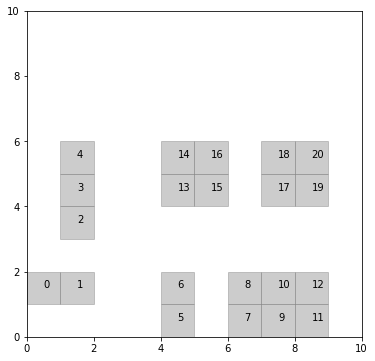

In [75]:
# 各テーブルの位置を指定します。テーブルの左下の座標を指定しています。
tables = [ [0,1], [1,1], [1,3], [1,4], [1,5], [4,0], [4,1], [6,0], [6,1],  [7,0],  [7,1],  [8,0],  [8,1],  [4,4],  [4,5],  [5,4],  [5,5],  [7,4],  [7,5],  [8,4],  [8,5]]

# テーブルのグループを指定します。
table_groups = {
    "A": [0, 1],
    "B": [2, 3, 4],
    "C": [5, 6],
    "D": [7, 8, 9, 10, 11, 12],
    "E": [13, 14, 15, 16],
    "F": [17, 18, 19, 20]
}

# お客さんのグループを指定します。数値は何人のグループかを表しています。
customer_groups = [
    (2),
    (3),
    (8),
    (6)
]

Nc = sum([x for x in customer_groups])
Nt = len(tables)
print(f"customer numbers: {Nc}, table numbers: {Nt}")
print(f"customer group members: {customer_groups}")

fig, ax = draw_table_layout(tables)
plt.show()

## イジングモデル設計

イジングモデルを設計するために以下を実施します。

- 決定変数の定義
- 制約条件の定義
- 目的関数の定義

### 決定変数

イジングモデルで扱える変数を設定します。ここでは，（各テーブルの数）×（人の数）のマトリックスqを用意し，i番目のテーブルにj番目の人が座れば $q_{ij}=1$，座らなければ $q_{ij}=0$ と定義します。


In [76]:
# 決定変数を (N_table x N_customers) の配列の形式で定義
gen = BinarySymbolGenerator()
q = gen.array(Nt, Nc)

### 制約条件

実現可能な解を出すため，以下２つの制約条件を設定します。

- 制約１：一人は必ず１つのテーブルを割り当てる
- 制約２：一つのテーブルには一人以下しか割り当てない


$N_c$を人の総数とすると，制約条件１は以下のように表せます。

$$
\sum_{i=0}^{N_t - 1}q_{i, j} = 1
\quad
\text{for  }  \ j \in \{0, \cdots, N_c - 1\}
$$

In [77]:
# 一人は一つのテーブル
table_constraints = [one_hot(q[:, j]) for j in range(Nc)]

$N_t$をテーブルの総数とすると，制約条件2は以下のように表せます。

$$
\sum_{j=0}^{N_c - 1} q_{i, j}< 1 \quad \text{for  }  \ i \in \{0, \cdots, N_t - 1\}
$$

In [78]:
# 一つのテーブルには一人
overlap_constraints = [less_equal(q[i, :], 1) for i in range(Nt)]

### 目的関数

以降では問題設定の箇所でも示した，「効率的な配置」について数式に落とし込んでいきます。

再掲しますが，「効率的な配置」とは以下のように定義しました。

- １．テーブルの座席数をなるべく埋める（４人掛けのテーブルにはなるべく４人グループを割り当てる）
- ２．グループが同じ人はなるべく近いテーブルに座らせる
- ３．他のグループとの距離はなるべく離す

#### １．テーブルをなるべく埋める

各テーブルは島を作っています。（４人席，６人席など）各島を${i_g}$とし，島に配置されたテーブルの数を$N_{i_g}$とします。この時，テーブルになるべく詰めるという条件は以下のように表せます。

$$
\min ( \sum_{i_g} \lbrace \lbrack - \sum_{i \in i_g} \sum_{j} q_{i, j} + N_{i_g}  \rbrack \cdot \sum_{i \in i_g} \sum_{j} q_{i, j} \rbrace) \quad 
$$

ここで，minの中で$\sum_{i \in i_g} \sum_{j} q_{i, j}$をかけているのは，ひとが一人も配置されなかった時のペナルティを０にするためです。


In [79]:
# テーブルにはなるべく詰める
g_table_indexes = group_table_indexes(table_groups)
table_functions = []
for idxs in g_table_indexes:
    capacity = len(idxs)
    occupy = sum([q[i, j] for j in range(Nc) for i in idxs])
    table_functions.append((-occupy + capacity) * occupy)
g1 = sum(table_functions)

#### ２．グループが同じ人はなるべく近いテーブルに座らせる


言い換えると，同じグループの人の位置がなるべく近くなればよいということになります。方針としては以下です。

- グループごとに割り当てられたテーブルの平均位置座標を算出する。
- 各座標軸それぞれについて，グループ内の位置の分散を計算する
- 各グループごとの分散の和が最小になるようにする

$$
min \lbrace \sum_{j_g} (\sum_{j \in j_g} q_{i, j} \cdot x_{center}^{(j)}  - avg_x^{(j_g)}) ^ 2  / n_c^{(j_g)} \rbrace \\
min \lbrace \sum_{j_g} (\sum_{j \in j_g} q_{i, j} \cdot y_{center}^{(j)}  - avg_y^{(j_g)}) ^ 2  / n_c^{(j_g)} \rbrace \\
$$

ここで，各変数は以下を意味することとします。


- $(x_{center}^{(j)}, y_{center}^{(j)})$：各人が割り当てられたテーブルの中心位置
- $j_g$：人のグループ
- $(avg_{x}^{(j_g)}, avg_{y}^{(j_g)})$：各グループごとの平均位置座標
- $n_c^{(j_g)}$：各グループに含まれる人の数



In [80]:
# グループ内のお互いの距離がなるべく近づくようにする
# グループ内の分散最小化

g_member_indexes = group_member_indexes(customer_groups)
table_indexes = range(len(tables))
# abs_dist_map = calc_abs_distance_map(tables)
center_points = calc_center_point_map(tables)

ux_functions = []
group_avg_coords = []
for member_indexes in g_member_indexes:
    n_c = len(member_indexes)
    # 原点からのグループ平均座標
    # avg = sum([q[i, j] * abs_dist_map[i] for i in table_indexes for j in member_indexes]) / n_c

    avg_coord_x = sum([q[i, j] * center_points[i][0] for i in table_indexes for j in member_indexes]) / n_c
    avg_coord_y = sum([q[i, j] * center_points[i][1] for i in table_indexes for j in member_indexes]) / n_c
    group_avg_coords.append((avg_coord_x, avg_coord_y))

    # グループ内距離分散
    var_x = sum([(sum([q[i, j] * center_points[i][0] for i in table_indexes]) - avg_coord_x) ** 2 for j in member_indexes]) / n_c
    var_y = sum([(sum([q[i, j] * center_points[i][1] for i in table_indexes]) - avg_coord_y) ** 2 for j in member_indexes]) / n_c
    ux_functions.append(var_x)
    ux_functions.append(var_y)


g2 = sum(ux_functions) 

#### ３．他のグループとの距離はなるべく離す

２と同様に考え，グループごとの平均位置の分散が最大になるようにします。

$$
\max( \sum_{j_g} \lbrace (avg_{x}^{(j_g)} - \text{avg}_x) ^ 2 \rbrace ) / N_g \\ 
\max( \sum_{j_g} \lbrace (avg_{y}^{(j_g)} - \text{avg}_y) ^ 2 \rbrace ) / N_g 
$$

ここで，

- ${N_g}$：グループの数
- $(avg_{x}, avg_{y})$：グループ単位の平均位置座標

また実装上，目的関数は最小値を求めるようにしたいので，最後にマイナスをつけています。


In [81]:
# グループ間の距離分散を最大にする
group_num= len(group_avg_coords)
group_global_avg_x = sum([coord[0] for coord in group_avg_coords]) / group_num
group_global_avg_y = sum([coord[1] for coord in group_avg_coords]) / group_num

group_vars_x = sum([(group_avg_coords[i][0] - group_global_avg_x)**2 for i in range(group_num)]) / group_num
group_vars_y = sum([(group_avg_coords[i][1] - group_global_avg_y)**2 for i in range(group_num)]) / group_num

g3 = -(group_vars_x + group_vars_y)

## 求解

前節で設定した制約条件と目的関数をまとめて問題を解きます。
また，各目的関数には重要度やオーダーに応じて重みを付けます。

In [82]:
# 制約条件と目的関数をまとめる
f = 0.1 * g1 + g2 + 0.01 * g3 + sum(table_constraints) + sum(overlap_constraints)

In [83]:
# クライアントの設定
client = FixstarsClient()
client.parameters.timeout = 1000  # タイムアウト1秒
client.token = FIXSTAR_CLIENT_TOKEN
client.parameters.outputs.duplicate = True  # 同じエネルギー値の解を列挙するオプション（解が複数個あるため）

# ソルバの設定と結果の取得
solver = Solver(client)

result = solver.solve(f)
print(f"Number of solutions: {len(result)}")

Number of solutions: 84


## 結果の確認

### 配置の描画

求めた結果を描画してみます。同じグループの人を同じ色で塗分けています。適切に配置できていることが確認できます。

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fefd6c02510>)

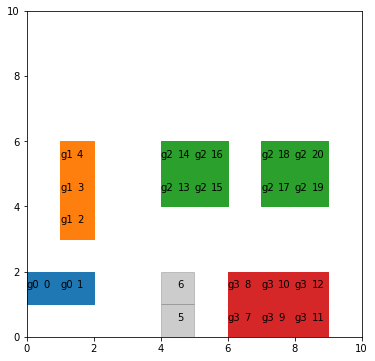

In [84]:
# 求めた解を元の変数に代入
values = result[0].values
solution = q.decode(values)
draw_solutions(solution, tables, customer_groups, xmax=10, ymax=10, figsize=(6, 6))

### 各目的関数の最終値を確認

In [85]:
val_g1 = g1.replace_all(values)
val_g2 = g2.replace_all(values)
val_g3 = g3.replace_all(values)
print(f" g1: {val_g1},\n g2: {val_g2}, \n g4: {val_g3}")

 g1: 0.0,
 g2: 4.583333333333328, 
 g4: -11.546874999999998


## まとめ


アニーリングマシンを用いて座席配置問題を解くために，イジングモデルを定義し適切に解を導出できることを確認できました。

改善案としては，以下が挙げられます。

- 定員オーバーの場合（座らせる席がない場合）を考慮する
- 希望座席，カウンター希望などの希望条件を考慮する
- 離着席のタイミングを考慮する（例：先に待っている４人を飛ばして，後のお一人様を通す。）

